In [1]:
import numpy as np
import re
from IPython.display import clear_output

from keras.layers import Dense, LSTM, Input, Embedding, Dropout
from keras.utils import np_utils
from keras.models import Model, load_model
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import LambdaCallback

Using TensorFlow backend.


In [2]:
load_saved_model = False
train_model = False

In [3]:
token_type = 'word'

In [4]:
#load in the text and perform some cleanup

seq_length = 20

filename = "./data/aesop/data.txt"

with open(filename, encoding='utf-8-sig') as f:
    text = f.read()
    
    
#removing text before and after the main stories
start = text.find("THE FOX AND THE GRAPES\n\n\n")
end = text.find("ILLUSTRATIONS\n\n\n[")
text = text[start:end]

In [5]:
start_story = '| ' * seq_length
    
text = start_story + text
text = text.lower()
text = text.replace('\n\n\n\n\n', start_story)
text = text.replace('\n', ' ')
text = re.sub('  +', '. ', text).strip()
text = text.replace('..', '.')

text = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~])', r' \1 ', text)
text = re.sub('\s{2,}', ' ', text)

In [6]:
len(text)

213694

In [7]:
text

' | | | | | | | | | | | | | | | | | | | | the fox and the grapes . a hungry fox saw some fine bunches of grapes hanging from a vine that was trained along a high trellis , and did his best to reach them by jumping as high as he could into the air . but it was all in vain , for they were just out of reach : so he gave up trying , and walked away with an air of dignity and unconcern , remarking , " i thought those grapes were ripe , but i see now they are quite sour . " | | | | | | | | | | | | | | | | | | | | the goose that laid the golden eggs . a man and his wife had the good fortune to possess a goose which laid a golden egg every day . lucky though they were , they soon began to think they were not getting rich fast enough , and , imagining the bird must be made of gold inside , they decided to kill it in order to secure the whole store of precious metal at once . but when they cut it open they found it was just like any other goose . thus , they neither got rich all at once , as the

In [8]:

if token_type == 'word':
    tokenizer = Tokenizer(char_level = False, filters = '')
else:
    tokenizer = Tokenizer(char_level = True, filters = '', lower = False)
    
    
tokenizer.fit_on_texts([text])

total_words = len(tokenizer.word_index) + 1

token_list = tokenizer.texts_to_sequences([text])[0]


In [9]:
total_words

4170

In [10]:
print(tokenizer.word_index)
print(token_list)

{'|': 1, ',': 2, 'the': 3, 'and': 4, '.': 5, 'a': 6, 'to': 7, '"': 8, 'of': 9, 'he': 10, 'his': 11, 'was': 12, 'you': 13, 'in': 14, 'him': 15, 'it': 16, 'for': 17, 'i': 18, 'but': 19, 'that': 20, 'with': 21, 'said': 22, 'they': 23, 'at': 24, 'as': 25, 'when': 26, 'on': 27, 'so': 28, 'by': 29, ':': 30, 'one': 31, 'had': 32, ';': 33, 'be': 34, 'them': 35, 'up': 36, 'all': 37, 'who': 38, '-': 39, 'her': 40, 'my': 41, 'is': 42, 'out': 43, 'me': 44, 'not': 45, 'your': 46, 'were': 47, 'which': 48, 'have': 49, 'their': 50, 'no': 51, 'lion': 52, 'she': 53, 'if': 54, 'into': 55, 'fox': 56, 'an': 57, 'what': 58, 'ass': 59, '!': 60, 'time': 61, 'from': 62, 'are': 63, 'came': 64, '?': 65, 'man': 66, 'do': 67, 'about': 68, 'there': 69, 'wolf': 70, 'then': 71, 'upon': 72, 'himself': 73, 'this': 74, 'day': 75, 'would': 76, 'some': 77, 'once': 78, 'will': 79, 'very': 80, 'went': 81, 'well': 82, 'than': 83, 'down': 84, 'replied': 85, 'got': 86, 'off': 87, 'could': 88, 'away': 89, 'see': 90, 'good': 91,

In [11]:
def generate_sequences(token_list, step):
    
    X = []
    y = []

    for i in range(0, len(token_list) - seq_length, step):
        X.append(token_list[i: i + seq_length])
        y.append(token_list[i + seq_length])
    

    y = np_utils.to_categorical(y, num_classes = total_words)
    
    num_seq = len(X)
    print('Number of sequences:', num_seq, "\n")
    
    return X, y, num_seq

step = 1
seq_length = 20

X, y, num_seq = generate_sequences(token_list, step)

X = np.array(X)
y = np.array(y)


Number of sequences: 50399 



In [12]:
X.shape

(50399, 20)

In [13]:
y.shape

(50399, 4170)

## Define the LSTM model

In [14]:
if load_saved_model:
    # model = load_model('./saved_models/lstm_aesop_1.h5')
    model = load_model('./saved_models/aesop_dropout_100.h5')

else:

    n_units = 256
    embedding_size = 100

    text_in = Input(shape = (None,))
    embedding = Embedding(total_words, embedding_size)
    x = embedding(text_in)
    x = LSTM(n_units)(x)
    # x = Dropout(0.2)(x)
    text_out = Dense(total_words, activation = 'softmax')(x)

    model = Model(text_in, text_out)

    opti = RMSprop(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opti)

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         417000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_1 (Dense)              (None, 4170)              1071690   
Total params: 1,854,258
Trainable params: 1,854,258
Non-trainable params: 0
_________________________________________________________________


In [16]:
def sample_with_temp(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



def generate_text(seed_text, next_words, model, max_sequence_len, temp):
    output_text = seed_text
    
    seed_text = start_story + seed_text
    
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-max_sequence_len:]
        token_list = np.reshape(token_list, (1, max_sequence_len))
        
        probs = model.predict(token_list, verbose=0)[0]
        y_class = sample_with_temp(probs, temperature = temp)
        
        if y_class == 0:
            output_word = ''
        else:
            output_word = tokenizer.index_word[y_class]
            
        if output_word == "|":
            break
            
        if token_type == 'word':
            output_text += output_word + ' '
            seed_text += output_word + ' '
        else:
            output_text += output_word + ' '
            seed_text += output_word + ' '
            
            
    return output_text

In [17]:
def on_epoch_end(epoch, logs):
    seed_text = ""
    gen_words = 500

    print('Temp 0.2')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.2))
    print('Temp 0.33')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.33))
    print('Temp 0.5')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.5))
    print('Temp 1.0')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 1))
    
if train_model:
    epochs = 1000
    batch_size = 32
    num_batches = int(len(X) / batch_size)
    callback = LambdaCallback(on_epoch_end=on_epoch_end)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks = [callback], shuffle = True)


In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         417000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_1 (Dense)              (None, 4170)              1071690   
Total params: 1,854,258
Trainable params: 1,854,258
Non-trainable params: 0
_________________________________________________________________


In [19]:
seed_text = "the frog and the snake . "
gen_words = 500
temp = 0.1

print (generate_text(seed_text, gen_words, model, seq_length, temp))

the frog and the snake . stopped slaughter dullness overjoyed tiny chatter victory water's death's care eggs proposals pomegranate horseman pretty flatly overtook likely suppose harmless derided falls ash listening abuse humming squeak suspected unwelcome agree smallest discussed fade spend belaboured turning returned feverish bulk legs worthy image refuge cattle swooped ugly statues add water's observed fuller knew daily bed free self kissed revive unjust produce spared murderous overripe knife concerned plunder proceeded olive service vine dog growing attempting universal denying o pickings frisk ant enmity mounting ages poverty spoil sweetness hercules violent bungling leaped tools pelted heavens wasted numb finish sling snapped house boots conversed settle crew helpless whisper armful wonder answer venus emerald prowess restored need kitchen mingled unlucky favour something ease keeping ugly understand frisk deafening attacks inflammable lot eagle seems rubbed mounted owner's you s

In [20]:
def generate_human_led_text(model, max_sequence_len):
    
    output_text = ''
    seed_text = start_story
    
    while 1:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-max_sequence_len:]
        token_list = np.reshape(token_list, (1, max_sequence_len))
        
        probs = model.predict(token_list, verbose=0)[0]

        top_10_idx = np.flip(np.argsort(probs)[-10:])
        top_10_probs = [probs[x] for x in top_10_idx]
        top_10_words = tokenizer.sequences_to_texts([[x] for x in top_10_idx])
        
        for prob, word in zip(top_10_probs, top_10_words):
            print('{:<6.1%} : {}'.format(prob, word))

        chosen_word = input()
                
        if chosen_word == '|':
            break  
        
        seed_text += chosen_word + ' '
        output_text += chosen_word + ' '
        
        clear_output()

        print (output_text)

In [21]:
generate_human_led_text(model, 10)

the owl sat on the branch fox is busy someone  tries to be kind 
0.0%   : feelings
0.0%   : nightingale
0.0%   : became
0.0%   : drag
0.0%   : working
0.0%   : noble
0.0%   : filched
0.0%   : where
0.0%   : flapping
0.0%   : intercourse
|


KeyboardInterrupt: 

In [20]:
# model.save('./saved_models/aesop_no_dropout_100.h5')

In [26]:
# attempt to straighten out the issues with seq2seq
# Keras API: https://keras.io/guides/functional_api/

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os
import re

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#nltk
import nltk

#stop-words
from nltk.corpus import stopwords
stop_words=set(nltk.corpus.stopwords.words('english'))

# tokenizing
from nltk import word_tokenize,sent_tokenize

#keras
import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, TimeDistributed
from keras.models import Model

def vocab_creator(text_lists, vocab_size):
    '''create vocabulary and return wrd-id and id-wrd mappings'''
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(text_lists)
    dictionary = tokenizer.word_index
    word2idx = {}
    idx2word = {}
    for k, v in dictionary.items():
        if v < vocab_size:
            word2idx[k] = v
            idx2word[v] = k
        if v >= vocab_size-1:
            continue
    return word2idx, idx2word

def txt2seq(txt, vocab):
    '''tokenize text and return list of tokens'''
    res = []
    for sent in txt: # txt is a list of sentences
        res.append([vocab[0][wrd] for wrd in sent.split()])
    return res

sample_text_1="bitty bought a bit of butter"
sample_text_2="but the bit of butter was a bit bitter"
sample_text_3="so she bought some better butter to make the bitter butter better"

corp = [sample_text_1, sample_text_2, sample_text_3] # corpus
no_docs = len(corp) # number of documents in corpus

vocab_size = 50 # size of vocabulary
#vocab = vocab_creator(text_lists, vocab_size)

encod_corp = []
for i, doc in enumerate(corp): # docs in corpus
    encod_corp.append(one_hot(doc,50))
    print("The encoding for document", i+1, " is : ", one_hot(doc,50))
    
# length of maximum document. will be nedded whenever create embeddings for the words
maxlen = -1
for doc in corp: # docs in corpus
    tokens = nltk.word_tokenize(doc) # tokenize document
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is : ", maxlen)

# now to create embeddings all of our docs need to be of same length. hence we can pad the docs with zeros.
pad_corp = pad_sequences(encod_corp, maxlen = maxlen, padding = 'post', value = 0.0)
print("No of padded documents: ", len(pad_corp))

for i, doc in enumerate(pad_corp):
     print("The padded encoding for document", i+1, " is : ", doc)

print('vocab_size: ', vocab_size)
print('maxlen: ', maxlen)

# clear old model
keras.backend.clear_session()
        
encoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
print('encoder_inputs: ', np.shape(encoder_inputs)) # (None, 12)
#encoder_embedding = embed_layer(encoder_inputs)
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=8, input_length=maxlen)(encoder_inputs)
print('encoder_embedding: ', np.shape(encoder_embedding)) # (None, 12, 8)
HIDDEN_DIM = 3
encoder_LSTM = LSTM(HIDDEN_DIM, return_state=True)

encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
print('encoder_outputs: ', np.shape(encoder_outputs)) # (None, 3)
print('state_h: ', np.shape(state_h)) # (None, 3)
print('state_c: ', np.shape(state_c)) # (None, 3)
decoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
print('decoder_inputs: ', np.shape(decoder_inputs)) # (None, 12)
#decoder_embedding = embed_layer(decoder_inputs)
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=8, input_length=maxlen)(decoder_inputs)
print('decoder_embedding: ', np.shape(decoder_embedding)) # (None, 12, 8)
decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)

decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c]) # no need to return hidden states
print('dec_out: ', np.shape(decoder_outputs)) # (None, 12, 3)

# dense_layer = Dense(VOCAB_SIZE, activation='softmax')
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.summary()
#keras.utils.plot_model(model, "seq2seq_t0.png", show_shapes=True)

print(outputs.shape)
print('outputs: ', np.shape(outputs)) # (None, 12, 50)

data_path = 'D:\BernieData\DeepL\data'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

#checkpointer = ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', verbose=1)

'''model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(valid_data) // (batch_size*num_steps), callbacks=[checkpointer])'''

# Actually training the model: (x=input data, y=target data)
# see https://www.tensorflow.org/api_docs/python/tf/keras/Model

# need to reshape to (samples, 12)

print('predict: ', np.shape(pad_corp)) # (3, 12)
print('predict: ', np.shape(pad_corp[0])) # (12, )
print(pad_corp[0])

x_train = np.array([pad_corp[i % 3] for i in range(12)]) # 12 samples generated
y_train = np.ones((12, 12, 50)) # shape (12, 50)
print('x_train: ', np.shape(x_train)) # (12,)
print('y_train: ', np.shape(y_train)) # (12,)

print(x_train)
print(y_train)

model.fit([x_train, x_train], y_train, epochs=1)

x_test = np.array([pad_corp[0] for i in range(1)]) # 1 sample generated
print(x_test)
prediction = model.predict([x_test, x_test])
print(prediction)
print(np.shape(prediction))

'''model = load_model(data_path + "\model-40.hdf5")
dummy_iters = 40
example_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,
                                                     skip_step=1)
print("Training data:")
for i in range(dummy_iters):
    dummy = next(example_training_generator.generate())
num_predict = 10
true_print_out = "Actual words: "
pred_print_out = "Predicted words: "
for i in range(num_predict):
    data = next(example_training_generator.generate())
    prediction = model.predict(data[0])
    predict_word = np.argmax(prediction[:, num_steps-1, :])
    true_print_out += reversed_dictionary[train_data[num_steps + dummy_iters + i]] + " "
    pred_print_out += reversed_dictionary[predict_word] + " "
print(true_print_out)
print(pred_print_out)'''

The encoding for document 1  is :  [19, 6, 9, 32, 1, 21]
The encoding for document 2  is :  [43, 28, 32, 1, 21, 12, 9, 32, 44]
The encoding for document 3  is :  [20, 15, 6, 45, 49, 21, 21, 10, 28, 44, 21, 49]
The maximum number of words in any document is :  12
No of padded documents:  3
The padded encoding for document 1  is :  [19  6  9 32  1 21  0  0  0  0  0  0]
The padded encoding for document 2  is :  [43 28 32  1 21 12  9 32 44  0  0  0]
The padded encoding for document 3  is :  [20 15  6 45 49 21 21 10 28 44 21 49]
vocab_size:  50
maxlen:  12
encoder_inputs:  (None, 12)
encoder_embedding:  (None, 12, 8)
encoder_outputs:  (None, 3)
state_h:  (None, 3)
state_c:  (None, 3)
decoder_inputs:  (None, 12)
decoder_embedding:  (None, 12, 8)
dec_out:  (None, 12, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (In

'model = load_model(data_path + "\\model-40.hdf5")\ndummy_iters = 40\nexample_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,\n                                                     skip_step=1)\nprint("Training data:")\nfor i in range(dummy_iters):\n    dummy = next(example_training_generator.generate())\nnum_predict = 10\ntrue_print_out = "Actual words: "\npred_print_out = "Predicted words: "\nfor i in range(num_predict):\n    data = next(example_training_generator.generate())\n    prediction = model.predict(data[0])\n    predict_word = np.argmax(prediction[:, num_steps-1, :])\n    true_print_out += reversed_dictionary[train_data[num_steps + dummy_iters + i]] + " "\n    pred_print_out += reversed_dictionary[predict_word] + " "\nprint(true_print_out)\nprint(pred_print_out)'

In [1]:
# perfect shuffle
def pshffl(lst):
    '''return lst perfectly shuffled once'''
    if len(lst) % 2 != 0:
        return lst
    l2 = int(len(lst) / 2)
    res = []
    for i in range(l2):
        res.append(lst[i])
        res.append(lst[l2+i])
    return res

def main():
    l0 = [1,2,3,4,5,6,7,8]
    l0 = pshffl(l0)
    print(l0)
    l0 = pshffl(l0)
    print(l0)
    l0 = pshffl(l0)
    print(l0)

if __name__=="__main__":
    main()

[1, 5, 2, 6, 3, 7, 4, 8]
[1, 3, 5, 7, 2, 4, 6, 8]
[1, 2, 3, 4, 5, 6, 7, 8]


In [30]:
# Wilson primality
import math

def wilsp(p):
    '''test primality of p via Wilsons theorem'''
    if p <= 1:
        return False
    return (math.factorial(p-1) + 1) % p == 0

def main():
    print(wilsp(1))
    print(wilsp(5))
    print(wilsp(13))
    print(wilsp(57))
    print(wilsp(123))

if __name__=="__main__":
    main()

False
True
True
False
False


In [1]:
# attempt to straighten out the issues with seq2seq
# Keras API: https://keras.io/guides/functional_api/

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os
import re

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#nltk
import nltk

#stop-words
from nltk.corpus import stopwords
stop_words=set(nltk.corpus.stopwords.words('english'))

# tokenizing
from nltk import word_tokenize,sent_tokenize

#keras
import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, TimeDistributed
from keras.models import Model

def vocab_creator(text_lists, vocab_size):
    '''create vocabulary and return wrd-id and id-wrd mappings'''
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(text_lists)
    dictionary = tokenizer.word_index
    word2idx = {}
    idx2word = {}
    for k, v in dictionary.items():
        if v < vocab_size:
            word2idx[k] = v
            idx2word[v] = k
        if v >= vocab_size-1:
            continue
    return word2idx, idx2word

def txt2seq(txt, vocab):
    '''tokenize text and return list of tokens'''
    res = []
    for sent in txt: # txt is a list of sentences
        res.append([vocab[0][wrd] for wrd in sent.split()])
    return res

sample_text_1="bitty bought a bit of butter"
sample_text_2="but the bit of butter was a bit bitter"
sample_text_3="so she bought some better butter to make the bitter butter better"

corp = [sample_text_1, sample_text_2, sample_text_3] # corpus
no_docs = len(corp) # number of documents in corpus

vocab_size = 50 # size of vocabulary
#vocab = vocab_creator(text_lists, vocab_size)

encod_corp = []
for i, doc in enumerate(corp): # docs in corpus
    encod_corp.append(one_hot(doc,50))
    print("The encoding for document", i+1, " is : ", one_hot(doc,50))
    
# length of maximum document. will be nedded whenever create embeddings for the words
maxlen = -1
for doc in corp: # docs in corpus
    tokens = nltk.word_tokenize(doc) # tokenize document
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is : ", maxlen)

# now to create embeddings all of our docs need to be of same length. hence we can pad the docs with zeros.
pad_corp = pad_sequences(encod_corp, maxlen = maxlen, padding = 'post', value = 0.0)
print("No of padded documents: ", len(pad_corp))

for i, doc in enumerate(pad_corp):
     print("The padded encoding for document", i+1, " is : ", doc)

print('vocab_size: ', vocab_size)
print('maxlen: ', maxlen)

# clear old model
keras.backend.clear_session()
        
encoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
print('encoder_inputs: ', np.shape(encoder_inputs)) # (None, 12)
#encoder_embedding = embed_layer(encoder_inputs)
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=8, input_length=maxlen)(encoder_inputs)
print('encoder_embedding: ', np.shape(encoder_embedding)) # (None, 12, 8)
HIDDEN_DIM = 3
encoder_LSTM = LSTM(HIDDEN_DIM, return_state=True)

encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
print('encoder_outputs: ', np.shape(encoder_outputs)) # (None, 3)
print('state_h: ', np.shape(state_h)) # (None, 3)
print('state_c: ', np.shape(state_c)) # (None, 3)
decoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
print('decoder_inputs: ', np.shape(decoder_inputs)) # (None, 12)
#decoder_embedding = embed_layer(decoder_inputs)
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=8, input_length=maxlen)(decoder_inputs)
print('decoder_embedding: ', np.shape(decoder_embedding)) # (None, 12, 8)
decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)

decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c]) # no need to return hidden states
print('dec_out: ', np.shape(decoder_outputs)) # (None, 12, 3)

# dense_layer = Dense(VOCAB_SIZE, activation='softmax')
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.summary()
#keras.utils.plot_model(model, "seq2seq_t0.png", show_shapes=True)

print(outputs.shape)
print('outputs: ', np.shape(outputs)) # (None, 12, 50)

data_path = 'D:\BernieData\DeepL\data'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

#checkpointer = ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', verbose=1)

'''model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(valid_data) // (batch_size*num_steps), callbacks=[checkpointer])'''

# Actually training the model: (x=input data, y=target data)
# see https://www.tensorflow.org/api_docs/python/tf/keras/Model

# need to reshape to (samples, 12)

print('predict: ', np.shape(pad_corp)) # (3, 12)
print('predict: ', np.shape(pad_corp[0])) # (12, )
print(pad_corp[0])

x_train = np.array([pad_corp[i % 3] for i in range(12)]) # 12 samples generated
y_train = np.ones((12, 12, 50)) # shape (12, 50)
print('x_train: ', np.shape(x_train)) # (12,)
print('y_train: ', np.shape(y_train)) # (12,)

print(x_train)
print(y_train)

model.fit([x_train, x_train], y_train, epochs=1)

x_test = np.array([pad_corp[0] for i in range(1)]) # 1 sample generated
print(x_test)
prediction = model.predict([x_test, x_test])
print(prediction)
print(np.shape(prediction))

'''model = load_model(data_path + "\model-40.hdf5")
dummy_iters = 40
example_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,
                                                     skip_step=1)
print("Training data:")
for i in range(dummy_iters):
    dummy = next(example_training_generator.generate())
num_predict = 10
true_print_out = "Actual words: "
pred_print_out = "Predicted words: "
for i in range(num_predict):
    data = next(example_training_generator.generate())
    prediction = model.predict(data[0])
    predict_word = np.argmax(prediction[:, num_steps-1, :])
    true_print_out += reversed_dictionary[train_data[num_steps + dummy_iters + i]] + " "
    pred_print_out += reversed_dictionary[predict_word] + " "
print(true_print_out)
print(pred_print_out)'''

Using TensorFlow backend.


The encoding for document 1  is :  [7, 34, 19, 6, 24, 7]
The encoding for document 2  is :  [21, 35, 6, 24, 7, 13, 19, 6, 2]
The encoding for document 3  is :  [5, 45, 34, 10, 39, 7, 47, 25, 35, 2, 7, 39]
The maximum number of words in any document is :  12
No of padded documents:  3
The padded encoding for document 1  is :  [ 7 34 19  6 24  7  0  0  0  0  0  0]
The padded encoding for document 2  is :  [21 35  6 24  7 13 19  6  2  0  0  0]
The padded encoding for document 3  is :  [ 5 45 34 10 39  7 47 25 35  2  7 39]
vocab_size:  50
maxlen:  12
encoder_inputs:  (None, 12)
encoder_embedding:  (None, 12, 8)
encoder_outputs:  (None, 3)
state_h:  (None, 3)
state_c:  (None, 3)
decoder_inputs:  (None, 12)
decoder_embedding:  (None, 12, 8)
dec_out:  (None, 12, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLa

'model = load_model(data_path + "\\model-40.hdf5")\ndummy_iters = 40\nexample_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,\n                                                     skip_step=1)\nprint("Training data:")\nfor i in range(dummy_iters):\n    dummy = next(example_training_generator.generate())\nnum_predict = 10\ntrue_print_out = "Actual words: "\npred_print_out = "Predicted words: "\nfor i in range(num_predict):\n    data = next(example_training_generator.generate())\n    prediction = model.predict(data[0])\n    predict_word = np.argmax(prediction[:, num_steps-1, :])\n    true_print_out += reversed_dictionary[train_data[num_steps + dummy_iters + i]] + " "\n    pred_print_out += reversed_dictionary[predict_word] + " "\nprint(true_print_out)\nprint(pred_print_out)'

In [2]:
# from https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
	# generate random sequence
	sequence_in = generate_sequence(n_in, cardinality)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	X = one_hot_encode(sequence_in, cardinality)
	y = one_hot_encode(sequence_out, cardinality)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))
	return X,y

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
# define model
model = Sequential()
model.add(LSTM(150, input_shape=(n_timesteps_in, n_features)))
model.add(RepeatVector(n_timesteps_in))
model.add(LSTM(150, return_sequences=True))
model.add(TimeDistributed(Dense(n_features, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# train LSTM
for epoch in range(5000):
	# generate new random sequence
	X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
	# fit model for one epoch on this sequence
	model.fit(X, y, epochs=1, verbose=2)
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
	X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
	yhat = model.predict(X, verbose=0)
	if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
		correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))
# spot check some examples
for _ in range(10):
	X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
	yhat = model.predict(X, verbose=0)
	print('Expected:', one_hot_decode(y[0]), 'Predicted', one_hot_decode(yhat[0]))

Epoch 1/1
 - 1s - loss: 3.9215 - accuracy: 0.0000e+00
Epoch 1/1
 - 0s - loss: 3.9062 - accuracy: 0.0000e+00
Epoch 1/1
 - 0s - loss: 3.9018 - accuracy: 0.0000e+00
Epoch 1/1
 - 0s - loss: 3.8867 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.8758 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.8687 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.8626 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.8598 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.8599 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.7945 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 3.7669 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.7683 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.7333 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.6893 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.7070 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.6590 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.5513 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.5569 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.3848 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.3182 - accur

Epoch 1/1
 - 0s - loss: 1.6743 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5817 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.7011 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5751 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5604 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6652 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6049 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5047 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5672 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5903 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.9129 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6208 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6492 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6429 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6682 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6275 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6735 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5751 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5429 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5376 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.6257 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5854 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6383 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5669 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6050 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6230 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6101 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5594 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6579 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6570 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.7337 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5359 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5767 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5682 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6361 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6467 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6012 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5994 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5654 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6156 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.6751 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1308 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5891 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.7074 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6030 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5792 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.7077 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6137 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6360 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5546 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6284 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6287 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5980 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6104 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6632 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5893 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1418 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5744 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6206 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6408 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.2267 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5121 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5301 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5587 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5298 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5022 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5078 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6162 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3937 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4607 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4795 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4413 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5915 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5139 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5481 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6153 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5467 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5788 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6441 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5224 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.3336 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4697 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3320 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6763 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5810 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2481 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1363 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5548 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0843 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4254 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.6062 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2299 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5845 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4442 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6052 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5060 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4369 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4715 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.8062 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2809 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.0305 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4359 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.7450 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2697 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2509 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.7994 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2805 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3631 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4093 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4335 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4016 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3702 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3756 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.6903 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3525 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4635 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4288 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1575 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4623 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2969 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.4642 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6056 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.7351 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3824 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4296 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4185 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4390 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0973 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4490 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.7819 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2580 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3298 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0388 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4045 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4402 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.2218 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4138 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5848 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2864 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4678 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.3396 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2970 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3553 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1765 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4387 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4407 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.7679 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1769 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2214 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2983 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3028 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1628 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1067 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2186 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5659 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0700 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3012 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3908 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1153 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3778 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 0.8780 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2980 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2192 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3427 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2740 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1133 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8169 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.6555 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.5560 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1638 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2539 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.6281 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7256 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1532 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7857 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2702 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.7587 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8369 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5264 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2591 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 1.4649 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0314 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6909 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0771 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4946 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5649 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3376 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.7778 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2384 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.4998 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.2466 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2031 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0704 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8231 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4480 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0611 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0506 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2684 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.8343 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3351 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 1.4983 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9576 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9561 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.9045 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6960 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7959 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0452 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2834 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0133 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5868 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3906 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6821 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.0907 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6024 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.7767 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0996 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.8718 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6889 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8681 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1131 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 0.6141 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6310 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0158 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3204 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2207 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9669 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1944 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.8873 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4324 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5759 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.9194 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.8916 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6438 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.0738 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0517 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8926 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8023 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8414 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2356 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5513 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.8538 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9505 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9577 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1344 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 2.0377 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1460 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7672 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6148 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4310 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2286 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.9290 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3862 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4652 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.8792 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1062 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8276 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2659 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0997 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.4876 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6814 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.4454 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7703 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8999 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7844 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8010 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5919 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5826 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4537 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5986 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6002 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5174 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5396 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6551 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7348 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1022 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2236 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6505 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0425 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1730 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0274 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 1.3859 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3411 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8419 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8222 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1748 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5222 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8821 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7414 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6273 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4552 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0390 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8388 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8924 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6254 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4736 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6507 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3201 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.1283 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2721 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7793 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.0956 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1885 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1667 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.1369 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7892 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.7661 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6449 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0873 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5556 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2982 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7012 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8500 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7368 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8609 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1366 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.6414 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7164 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2107 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4727 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.3931 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 0.4385 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9981 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.6497 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3243 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8951 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7537 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9466 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0375 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7529 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5179 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.1829 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4719 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5000 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.3396 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.7599 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6133 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0875 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0562 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7787 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7366 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.7210 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7358 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7165 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6691 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6404 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9548 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1074 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1060 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7083 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7800 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7998 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3693 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.9840 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0733 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4208 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.4283 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.5115 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7879 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5104 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.4240 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.6213 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0442 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1340 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.4822 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1201 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.4022 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6613 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8492 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7137 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4537 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7036 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8394 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6272 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2905 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.8367 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5738 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4115 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7632 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6955 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2015 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.6034 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4857 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0300 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3069 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0438 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4741 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0197 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5311 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5277 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9984 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4620 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4348 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6821 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3661 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8223 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5420 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5737 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6573 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6036 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7541 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.5523 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6704 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8043 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.6015 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6985 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7260 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7765 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7269 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5770 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9492 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4826 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8295 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7530 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4889 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9390 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5211 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8717 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6060 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5305 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8654 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.5874 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7527 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5094 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6853 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7046 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.4059 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5210 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5414 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8497 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0199 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3621 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4532 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7017 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7943 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9274 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4064 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7356 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6432 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3465 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0835 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.7192 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5383 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9344 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.5528 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9282 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4514 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5688 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9015 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9746 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0549 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6741 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8627 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4856 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4910 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5158 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6273 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3490 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5005 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7805 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5115 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 1.1303 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7404 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9841 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0505 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7294 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4760 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4053 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6631 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8128 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4903 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4632 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9563 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8208 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7343 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7338 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0324 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5519 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4298 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7355 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5424 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.8928 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7154 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0843 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3276 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7994 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3427 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9074 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4531 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3569 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4528 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4761 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3327 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6803 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7878 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4397 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7086 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5961 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3218 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6458 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8745 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.6316 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3919 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4714 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9347 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4032 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4452 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6109 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6045 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3620 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4905 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3541 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.9961 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6466 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2278 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6913 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6280 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5443 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9636 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5068 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8162 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.3834 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5122 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4280 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4630 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4230 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4760 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5071 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6070 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2831 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6402 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5074 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5359 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6140 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5121 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4722 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6167 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8207 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6358 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7279 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4088 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.6724 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9985 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4293 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2715 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0574 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3778 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.8973 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6040 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8426 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6782 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4742 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4303 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5814 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6125 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4281 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.2491 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4725 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8534 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3606 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6585 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.8141 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8671 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9359 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4536 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4673 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6517 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2290 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.8763 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0428 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6767 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6744 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5263 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2074 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6764 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6178 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4054 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6653 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5950 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7485 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4895 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.6389 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5997 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3547 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4311 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6000 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7685 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7369 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4191 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1215 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6284 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7252 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4767 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6986 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3219 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3103 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7044 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4931 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4677 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9807 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4996 - accuracy: 0.8000


In [6]:
import tensorflow as tf
from keras import backend as K
from keras import regularizers, constraints, initializers, activations
#from keras.layers.recurrent import Recurrent, _time_distributed_dense
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec

def _time_distributed_dense(x, w, b=None, dropout=None,
                        input_dim=None, output_dim=None,
                        timesteps=None, training=None):
    """Apply `y . w + b` for every temporal slice y of x.
    # Arguments
        x: input tensor.
        w: weight matrix.
        b: optional bias vector.
        dropout: wether to apply dropout (same dropout mask
            for every temporal slice of the input).
        input_dim: integer; optional dimensionality of the input.
        output_dim: integer; optional dimensionality of the output.
        timesteps: integer; optional number of timesteps.
        training: training phase tensor or boolean.
    # Returns
        Output tensor.
    """
    if not input_dim:
        input_dim = K.shape(x)[2]
    if not timesteps:
        timesteps = K.shape(x)[1]
    if not output_dim:
        output_dim = K.shape(w)[1]

    if dropout is not None and 0. < dropout < 1.:
        # apply the same dropout pattern at every timestep
        ones = K.ones_like(K.reshape(x[:, 0, :], (-1, input_dim)))
        dropout_matrix = K.dropout(ones, dropout)
        expanded_dropout_matrix = K.repeat(dropout_matrix, timesteps)
        x = K.in_train_phase(x * expanded_dropout_matrix, x, training=training)

    # collapse time dimension and batch dimension together
    x = K.reshape(x, (-1, input_dim))
    x = K.dot(x, w)
    if b is not None:
        x = K.bias_add(x, b)
    # reshape to 3D tensor
    if K.backend() == 'tensorflow':
        x = K.reshape(x, K.stack([-1, timesteps, output_dim]))
        x.set_shape([None, None, output_dim])
    else:
        x = K.reshape(x, (-1, timesteps, output_dim))
    return x

tfPrint = lambda d, T: tf.Print(input_=T, data=[T, tf.shape(T)], message=d)

class AttentionDecoder(Recurrent):

    def __init__(self, units, output_dim,
                 activation='tanh',
                 return_probabilities=False,
                 name='AttentionDecoder',
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """
        Implements an AttentionDecoder that takes in a sequence encoded by an
        encoder and outputs the decoded states
        :param units: dimension of the hidden state and the attention matrices
        :param output_dim: the number of labels in the output space

        references:
            Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio.
            "Neural machine translation by jointly learning to align and translate."
            arXiv preprint arXiv:1409.0473 (2014).
        """
        self.units = units
        self.output_dim = output_dim
        self.return_probabilities = return_probabilities
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionDecoder, self).__init__(**kwargs)
        self.name = name
        self.return_sequences = True  # must return sequences

    def build(self, input_shape):
        """
          See Appendix 2 of Bahdanau 2014, arXiv:1409.0473
          for model details that correspond to the matrices here.
        """

        self.batch_size, self.timesteps, self.input_dim = input_shape

        if self.stateful:
            super(AttentionDecoder, self).reset_states()

        self.states = [None, None]  # y, s

        """
            Matrices for creating the context vector
        """

        self.V_a = self.add_weight(shape=(self.units,),
                                   name='V_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.W_a = self.add_weight(shape=(self.units, self.units),
                                   name='W_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.U_a = self.add_weight(shape=(self.input_dim, self.units),
                                   name='U_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.b_a = self.add_weight(shape=(self.units,),
                                   name='b_a',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the r (reset) gate
        """
        self.C_r = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_r = self.add_weight(shape=(self.units, self.units),
                                   name='U_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_r = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_r = self.add_weight(shape=(self.units, ),
                                   name='b_r',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        """
            Matrices for the z (update) gate
        """
        self.C_z = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_z = self.add_weight(shape=(self.units, self.units),
                                   name='U_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_z = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_z = self.add_weight(shape=(self.units, ),
                                   name='b_z',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the proposal
        """
        self.C_p = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_p = self.add_weight(shape=(self.units, self.units),
                                   name='U_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_p = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_p = self.add_weight(shape=(self.units, ),
                                   name='b_p',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for making the final prediction vector
        """
        self.C_o = self.add_weight(shape=(self.input_dim, self.output_dim),
                                   name='C_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_o = self.add_weight(shape=(self.units, self.output_dim),
                                   name='U_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_o = self.add_weight(shape=(self.output_dim, self.output_dim),
                                   name='W_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_o = self.add_weight(shape=(self.output_dim, ),
                                   name='b_o',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        # For creating the initial state:
        self.W_s = self.add_weight(shape=(self.input_dim, self.units),
                                   name='W_s',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)

        self.input_spec = [
            InputSpec(shape=(self.batch_size, self.timesteps, self.input_dim))]
        self.built = True

    def call(self, x):
        # store the whole sequence so we can "attend" to it at each timestep
        self.x_seq = x

        # apply the a dense layer over the time dimension of the sequence
        # do it here because it doesn't depend on any previous steps
        # thefore we can save computation time:
        self._uxpb = _time_distributed_dense(self.x_seq, self.U_a, b=self.b_a,
                                             input_dim=self.input_dim,
                                             timesteps=self.timesteps,
                                             output_dim=self.units)

        return super(AttentionDecoder, self).call(x)

    def get_initial_state(self, inputs):
        # apply the matrix on the first time step to get the initial s0.
        s0 = activations.tanh(K.dot(inputs[:, 0], self.W_s))

        # from keras.layers.recurrent to initialize a vector of (batchsize,
        # output_dim)
        y0 = K.zeros_like(inputs)  # (samples, timesteps, input_dims)
        y0 = K.sum(y0, axis=(1, 2))  # (samples, )
        y0 = K.expand_dims(y0)  # (samples, 1)
        y0 = K.tile(y0, [1, self.output_dim])

        return [y0, s0]

    def step(self, x, states):

        ytm, stm = states

        # repeat the hidden state to the length of the sequence
        _stm = K.repeat(stm, self.timesteps)

        # now multiplty the weight matrix with the repeated hidden state
        _Wxstm = K.dot(_stm, self.W_a)

        # calculate the attention probabilities
        # this relates how much other timesteps contributed to this one.
        et = K.dot(activations.tanh(_Wxstm + self._uxpb),
                   K.expand_dims(self.V_a))
        at = K.exp(et)
        at_sum = K.sum(at, axis=1)
        at_sum_repeated = K.repeat(at_sum, self.timesteps)
        at /= at_sum_repeated  # vector of size (batchsize, timesteps, 1)

        # calculate the context vector
        context = K.squeeze(K.batch_dot(at, self.x_seq, axes=1), axis=1)
        # ~~~> calculate new hidden state
        # first calculate the "r" gate:

        rt = activations.sigmoid(
            K.dot(ytm, self.W_r)
            + K.dot(stm, self.U_r)
            + K.dot(context, self.C_r)
            + self.b_r)

        # now calculate the "z" gate
        zt = activations.sigmoid(
            K.dot(ytm, self.W_z)
            + K.dot(stm, self.U_z)
            + K.dot(context, self.C_z)
            + self.b_z)

        # calculate the proposal hidden state:
        s_tp = activations.tanh(
            K.dot(ytm, self.W_p)
            + K.dot((rt * stm), self.U_p)
            + K.dot(context, self.C_p)
            + self.b_p)

        # new hidden state:
        st = (1-zt)*stm + zt * s_tp

        yt = activations.softmax(
            K.dot(ytm, self.W_o)
            + K.dot(stm, self.U_o)
            + K.dot(context, self.C_o)
            + self.b_o)

        if self.return_probabilities:
            return at, [yt, st]
        else:
            return yt, [yt, st]

    def compute_output_shape(self, input_shape):
        """
            For Keras internal compatability checking
        """
        if self.return_probabilities:
            return (None, self.timesteps, self.timesteps)
        else:
            return (None, self.timesteps, self.output_dim)

    def get_config(self):
        """
            For rebuilding models on load time.
        """
        config = {
            'output_dim': self.output_dim,
            'units': self.units,
            'return_probabilities': self.return_probabilities
        }
        base_config = super(AttentionDecoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
#from attention_decoder import AttentionDecoder

# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
	# generate random sequence
	sequence_in = generate_sequence(n_in, cardinality)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	X = one_hot_encode(sequence_in, cardinality)
	y = one_hot_encode(sequence_out, cardinality)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))
	return X,y

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2

# define model
model = Sequential()
model.add(LSTM(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
model.add(AttentionDecoder(150, n_features))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# train LSTM
for epoch in range(5000):
	# generate new random sequence
	X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
	# fit model for one epoch on this sequence
	model.fit(X, y, epochs=1, verbose=2)
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
	X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
	yhat = model.predict(X, verbose=0)
	if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
		correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))
# spot check some examples
for _ in range(10):
	X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
	yhat = model.predict(X, verbose=0)
	print('Expected:', one_hot_decode(y[0]), 'Predicted', one_hot_decode(yhat[0]))

Epoch 1/1
 - 1s - loss: 3.8663 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.8790 - accuracy: 0.2000
Epoch 1/1
 - 0s - loss: 3.8625 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.8435 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.8118 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.7984 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.7578 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.7629 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.7173 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.6358 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 3.6449 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.6257 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.6072 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.5596 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.4876 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.5060 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.3976 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.3373 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.2819 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 3.2553 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.6484 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5671 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5590 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5686 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.6545 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6829 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5176 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5191 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5679 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.6461 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4913 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6401 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6453 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5803 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6193 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5052 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5547 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6164 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4994 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5526 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.5603 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2845 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.4297 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5074 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5765 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3710 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4440 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5361 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4019 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4281 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5094 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4573 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3777 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4051 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5805 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.6767 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5436 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3444 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5640 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4752 - accuracy: 0.6000


Epoch 1/1
 - 0s - loss: 1.4979 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2977 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3472 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5774 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0873 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3645 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.1181 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.3472 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3344 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.5579 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.5642 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3717 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.6923 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4594 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4490 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3921 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8157 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1234 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4082 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.3752 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.7266 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9457 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8993 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2805 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0462 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.6840 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7098 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.0267 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7231 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.6482 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.9046 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0098 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.4114 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7259 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3008 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2793 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9357 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4606 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.9710 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6449 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.9323 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7086 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7586 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7065 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.9584 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.4041 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5750 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0214 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3337 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3933 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.8302 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8006 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8357 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4464 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5539 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9784 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0932 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.2398 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4962 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9343 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.8578 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1074 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0102 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4094 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2845 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6076 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5097 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5202 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9929 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7439 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6927 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0620 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7056 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0365 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 1.0353 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4425 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4829 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9228 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5949 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.8026 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 1.0841 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4931 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6258 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5544 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3537 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6048 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9945 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2500 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5467 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2036 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.0527 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4069 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.9483 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5589 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5125 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9097 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8413 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5087 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4599 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.8492 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.3370 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.1865 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.1852 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.2450 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4840 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2762 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2510 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4286 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6403 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4729 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5101 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5082 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5017 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.8401 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1500 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4880 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3475 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4007 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3892 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.0465 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 1.2532 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3004 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1712 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4182 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7967 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7270 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5179 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1940 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7431 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4392 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4681 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4737 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5566 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4989 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3599 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2199 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1813 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7937 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2178 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.1532 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3317 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2674 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.1740 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1216 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3412 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5111 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1629 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2787 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1037 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0832 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3548 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3166 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5677 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.8190 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1079 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2130 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2484 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5480 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4427 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.2790 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0589 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0462 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6531 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7997 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1832 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3599 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1248 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 1.2909 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2448 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0716 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5129 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0632 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1987 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0846 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6469 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5420 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.9028 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 1.3148 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.6425 - accuracy: 0.8000


Epoch 1/1
 - 0s - loss: 0.4229 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0565 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4205 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2327 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0741 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0441 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0192 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2829 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.7949 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3860 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2485 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0343 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1797 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3014 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5171 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3926 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2497 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1087 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3513 - accuracy: 0.6000
Epoch 1/1
 - 0s - loss: 0.0540 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.5028 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1670 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0551 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0227 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1115 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3070 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6055 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0746 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2323 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.7525 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0613 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2173 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0700 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5704 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3869 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4744 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1362 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1422 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5149 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0587 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0292 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3097 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0396 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2343 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4197 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4220 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0527 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3166 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0824 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0656 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3426 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3323 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5202 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5878 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2441 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0917 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0596 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4566 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0699 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2860 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.1278 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1036 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1118 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0521 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1439 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0975 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6875 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3210 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2110 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0055 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2184 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5230 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1913 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3037 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4971 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5146 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4505 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.3470 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1515 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2056 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0501 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0293 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0197 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0822 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1763 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.4356 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0331 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1610 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1403 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1793 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1338 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1618 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4885 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1303 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0147 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0082 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.5682 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0188 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2524 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0586 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.2017 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0420 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0854 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6344 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0064 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2040 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0873 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0045 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3775 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.5149 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0374 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2558 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0405 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.6420 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0741 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1285 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0640 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2198 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0372 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0276 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0502 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0651 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1938 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0885 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0123 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0348 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0839 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0839 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0519 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0815 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0441 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2711 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1035 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0737 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1231 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0143 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0835 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0440 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1473 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0542 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0317 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1339 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0492 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1697 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0181 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0787 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0177 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0964 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0212 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2377 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0394 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0316 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0585 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2333 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0180 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0632 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0445 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3259 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0658 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0198 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0250 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0408 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0122 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0748 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0084 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0488 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0230 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0275 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0566 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.8121 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.2297 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0061 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2031 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1801 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0877 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0252 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0076 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2579 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0289 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0144 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1352 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0305 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2158 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.1612 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0314 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0221 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1872 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0092 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1150 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0884 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1237 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0110 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2423 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0551 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2384 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0111 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0406 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2256 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0264 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.1151 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0105 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1062 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0252 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0831 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0095 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1772 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1335 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0574 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0725 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0106 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0100 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0193 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0140 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0050 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1580 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0168 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2142 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0128 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0854 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0383 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0391 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0028 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0097 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1447 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0742 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1940 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0141 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0677 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0296 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1881 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0314 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0096 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0166 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1390 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1766 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0032 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0082 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0147 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0277 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0396 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0058 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0919 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3122 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0102 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0069 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0597 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0268 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0071 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0152 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0047 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0104 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0107 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1456 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0277 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0136 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0109 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0068 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0151 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0597 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0392 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0058 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0248 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0026 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0155 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0145 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0029 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0050 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0088 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0064 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0903 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2268 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0082 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 8.1870e-04 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0964 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0093 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0548 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0237 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0351 - accuracy: 1.0

Epoch 1/1
 - 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0043 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0437 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1319 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0068 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0099 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4671 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0119 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1880 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0148 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0219 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0877 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0205 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0432 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0156 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0060 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0204 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0353 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0514 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.6371 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0280 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0321 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0076 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0054 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2079 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0310 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0091 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0138 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0286 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0718 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1350 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0067 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.3421 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0330 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0951 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0239 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0015 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.1025 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0282 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0490 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0088 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2116 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0217 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.4702 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0081 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0035 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0352 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0111 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0138 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0281 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0076 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0091 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0457 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2728 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 0.0192 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0383 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0052 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0061 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0355 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0297 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0090 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0217 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0078 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0173 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0974 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0114 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0620 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.1456 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0019 - accuracy: 1.0000


Epoch 1/1
 - 0s - loss: 0.0215 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0163 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0084 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0025 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0061 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0046 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.2766 - accuracy: 0.8000
Epoch 1/1
 - 0s - loss: 5.9909e-04 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0184 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0068 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0425 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0106 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0174 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0046 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0087 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 0.0090 - accuracy: 1.0000
Epoch 1/1
 - 0s - loss: 6.1665e-04 - accuracy:

In [9]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
#from attention_decoder import AttentionDecoder

# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
	# generate random sequence
	sequence_in = generate_sequence(n_in, cardinality)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	X = one_hot_encode(sequence_in, cardinality)
	y = one_hot_encode(sequence_out, cardinality)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))
	return X,y

# define the encoder-decoder model
def baseline_model(n_timesteps_in, n_features):
	model = Sequential()
	model.add(LSTM(150, input_shape=(n_timesteps_in, n_features)))
	model.add(RepeatVector(n_timesteps_in))
	model.add(LSTM(150, return_sequences=True))
	model.add(TimeDistributed(Dense(n_features, activation='softmax')))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# define the encoder-decoder with attention model
def attention_model(n_timesteps_in, n_features):
	model = Sequential()
	model.add(LSTM(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
	model.add(AttentionDecoder(150, n_features))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# train and evaluate a model, return accuracy
def train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features):
	# train LSTM
	for epoch in range(5000):
		# generate new random sequence
		X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
		# fit model for one epoch on this sequence
		model.fit(X, y, epochs=1, verbose=0)
	# evaluate LSTM
	total, correct = 100, 0
	for _ in range(total):
		X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
		yhat = model.predict(X, verbose=0)
		if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
			correct += 1
	return float(correct)/float(total)*100.0

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_repeats = 10
# evaluate encoder-decoder model
print('Encoder-Decoder Model')
results = list()
for _ in range(n_repeats):
	model = baseline_model(n_timesteps_in, n_features)
	accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features)
	results.append(accuracy)
	print(accuracy)
print('Mean Accuracy: %.2f%%' % (sum(results)/float(n_repeats)))
# evaluate encoder-decoder with attention model
print('Encoder-Decoder With Attention Model')
results = list()
for _ in range(n_repeats):
	model = attention_model(n_timesteps_in, n_features)
	accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features)
	results.append(accuracy)
	print(accuracy)
print('Mean Accuracy: %.2f%%' % (sum(results)/float(n_repeats)))

Encoder-Decoder Model
16.0
25.0
14.000000000000002
23.0
14.000000000000002
19.0
20.0
18.0
24.0
20.0
Mean Accuracy: 19.30%
Encoder-Decoder With Attention Model
94.0
98.0
97.0
96.0
100.0
100.0
98.0
98.0
98.0
98.0
Mean Accuracy: 97.70%


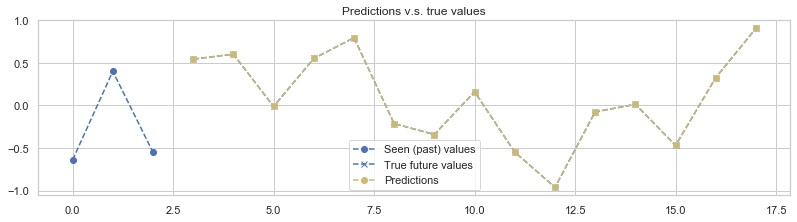

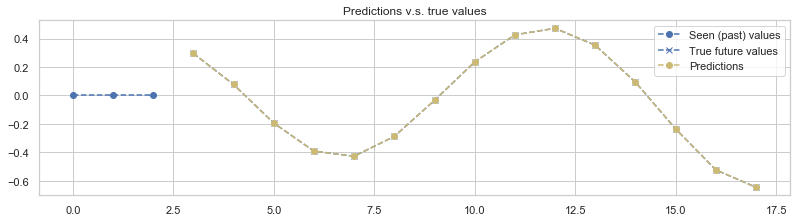

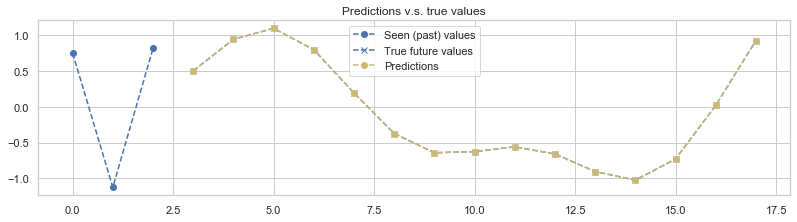

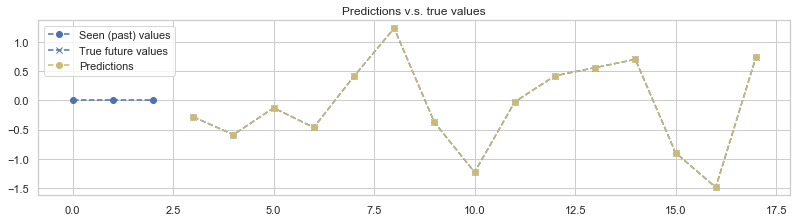

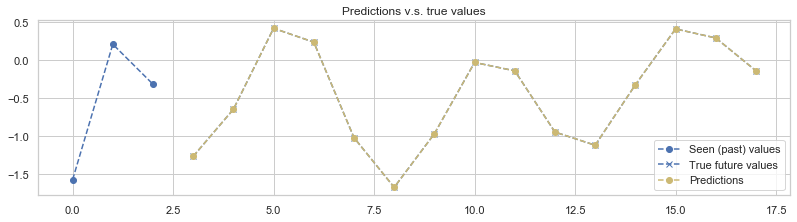

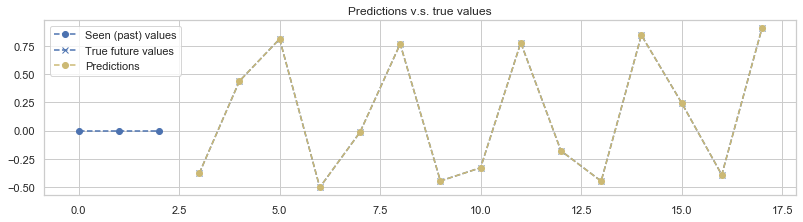

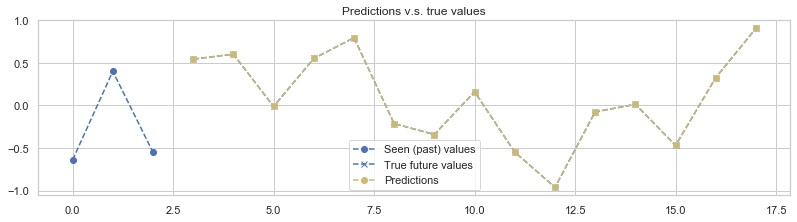

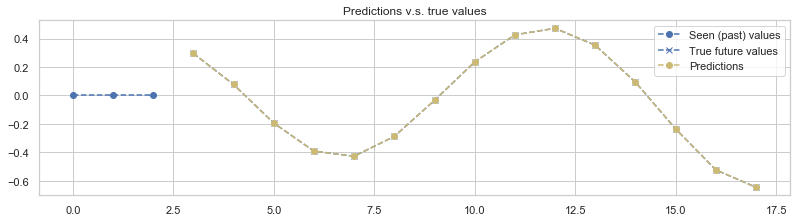

In [25]:
# from https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction

# This file contains code modified licensed under the MIT License:
# Copyright (c) 2017 Guillaume Chevalier # For more information, visit:
# https://github.com/guillaume-chevalier/seq2seq-signal-prediction
# https://github.com/guillaume-chevalier/seq2seq-signal-prediction/blob/master/LICENSE

"""Contains functions to generate artificial data for predictions as well as 
a function to plot predictions."""

import numpy as np
from matplotlib import pyplot as plt

def random_sine(batch_size, steps_per_epoch,
                input_sequence_length, target_sequence_length,
                min_frequency=0.1, max_frequency=10,
                min_amplitude=0.1, max_amplitude=1,
                min_offset=-0.5, max_offset=0.5,
                num_signals=3, seed=43):
    """Produce a batch of signals.
    The signals are the sum of randomly generated sine waves.
    Arguments
    ---------
    batch_size: Number of signals to produce.
    steps_per_epoch: Number of batches of size batch_size produced by the
        generator.
    input_sequence_length: Length of the input signals to produce.
    target_sequence_length: Length of the target signals to produce.
    min_frequency: Minimum frequency of the base signals that are summed.
    max_frequency: Maximum frequency of the base signals that are summed.
    min_amplitude: Minimum amplitude of the base signals that are summed.
    max_amplitude: Maximum amplitude of the base signals that are summed.
    min_offset: Minimum offset of the base signals that are summed.
    max_offset: Maximum offset of the base signals that are summed.
    num_signals: Number of signals that are summed together.
    seed: The seed used for generating random numbers
    
    Returns
    -------
    signals: 2D array of shape (batch_size, sequence_length)
    """
    num_points = input_sequence_length + target_sequence_length
    x = np.arange(num_points) * 2*np.pi/30

    while True:
        # Reset seed to obtain same sequences from epoch to epoch
        np.random.seed(seed)

        for _ in range(steps_per_epoch):
            signals = np.zeros((batch_size, num_points))
            for _ in range(num_signals):
                # Generate random amplitude, frequence, offset, phase 
                amplitude = (np.random.rand(batch_size, 1) * 
                            (max_amplitude - min_amplitude) +
                             min_amplitude)
                frequency = (np.random.rand(batch_size, 1) * 
                            (max_frequency - min_frequency) + 
                             min_frequency)
                offset = (np.random.rand(batch_size, 1) * 
                         (max_offset - min_offset) + 
                          min_offset)
                phase = np.random.rand(batch_size, 1) * 2 * np.pi 
                         

                signals += amplitude * np.sin(frequency * x + phase)
            signals = np.expand_dims(signals, axis=2)
            
            encoder_input = signals[:, :input_sequence_length, :]
            decoder_output = signals[:, input_sequence_length:, :]
            
            # The output of the generator must be ([encoder_input, decoder_input], [decoder_output])
            decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))
            yield ([encoder_input, decoder_input], decoder_output)

def plot_prediction(x, y_true, y_pred):
    """Plots the predictions.
    
    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """

    plt.figure(figsize=(12, 3))

    output_dim = x.shape[-1]
    for j in range(output_dim):
        past = x[:, j] 
        true = y_true[:, j]
        pred = y_pred[:, j]

        label1 = "Seen (past) values" if j==0 else "_nolegend_"
        label2 = "True future values" if j==0 else "_nolegend_"
        label3 = "Predictions" if j==0 else "_nolegend_"

        plt.plot(range(len(past)), past, "o--b",
                 label=label1)
        plt.plot(range(len(past),
                 len(true)+len(past)), true, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y",
                 label=label3)
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

if __name__ == '__main__':
    # This is an example of the plot function and the signal generator
    from matplotlib import pyplot as plt
    gen = random_sine(3, 3, 15, 15)
    for i, data in enumerate(gen):
        input_seq, output_seq = data
        #for j in range(input_seq.shape[0]):
        for j in range(np.shape(input_seq)[0]):
            #plot_prediction(input_seq[j, :, :],
                            #output_seq[j, :, :],
                            #output_seq[j, :, :])
            plot_prediction(input_seq[j][:,:],
                            output_seq[j][:,:],
                            output_seq[j][:,:])
        if i > 2:
            break

In [27]:
import numpy as np
import keras

#from utils import random_sine, plot_prediction

keras.backend.clear_session()

layers = [35, 35] # Number of hidden neuros in each layer of the encoder and decoder

learning_rate = 0.01
decay = 0 # Learning rate decay
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

num_input_features = 1 # The dimensionality of the input at each time step. In this case a 1D signal.
num_output_features = 1 # The dimensionality of the output at each time step. In this case a 1D signal.
# There is no reason for the input sequence to be of same dimension as the ouput sequence.
# For instance, using 3 input signals: consumer confidence, inflation and house prices to predict the future house prices.

loss = "mse" # Other loss functions are possible, see Keras documentation.

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

batch_size = 512
steps_per_epoch = 200 # batch_size * steps_per_epoch = total number of training examples
epochs = 15

input_sequence_length = 15 # Length of the sequence used by the encoder
target_sequence_length = 15 # Length of the sequence predicted by the decoder
num_steps_to_predict = 20 # Length to use when testing the model

num_signals = 2 # The number of random sine waves the compose the signal. The more sine waves, the harder the problem.



In [28]:
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]
   
# The decoder input will be set to zero (see random_sine function of the utils module).
# Do not worry about the input size being 1, I will explain that in the next cell.
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

# Create a model using the functional API provided by Keras.
# The functional API is great, it gives an amazing amount of freedom in architecture of your NN.
# A read worth your time: https://keras.io/getting-started/functional-api-guide/ 
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer=optimiser, loss=loss)

# random_sine returns a generator that produces batches of training samples ([encoder_input, decoder_input], decoder_output)
# You can play with the min max frequencies of the sine waves, the number of sine waves that are summed etc...
# Another interesing exercise could be to see whether the model generalises well on sums of 3 signals if it's only been
# trained on sums of 2 signals...
train_data_generator = random_sine(batch_size=batch_size,
                                   steps_per_epoch=steps_per_epoch,
                                   input_sequence_length=input_sequence_length,
                                   target_sequence_length=target_sequence_length,
                                   min_frequency=0.1, max_frequency=10,
                                   min_amplitude=0.1, max_amplitude=1,
                                   min_offset=-0.5, max_offset=0.5,
                                   num_signals=num_signals, seed=1969)

model.fit_generator(train_data_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)



Epoch 1/15
200/200 [==============================] - 14s 71ms/step - loss: 0.2699
Epoch 2/15
200/200 [==============================] - 13s 65ms/step - loss: 0.1767 3s - loss
Epoch 3/15
200/200 [==============================] - 15s 76ms/step - loss: 0.1584
Epoch 4/15
200/200 [==============================] - 13s 63ms/step - loss: 0.1210
Epoch 5/15
200/200 [==============================] - 13s 63ms/step - loss: 0.0683
Epoch 6/15
200/200 [==============================] - 13s 63ms/step - loss: 0.0498
Epoch 7/15
200/200 [==============================] - 13s 64ms/step - loss: 0.0396
Epoch 8/15
200/200 [==============================] - 12s 62ms/step - loss: 0.0342
Epoch 9/15
200/200 [==============================] - 12s 61ms/step - loss: 0.0304
Epoch 10/15
200/200 [==============================] - 12s 61ms/step - loss: 0.0278
Epoch 11/15
200/200 [==============================] - 12s 61ms/step - loss: 0.0259
Epoch 12/15
200/200 [==============================] - 13s 64ms/step - loss

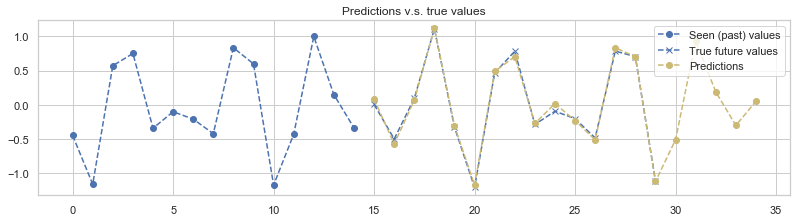

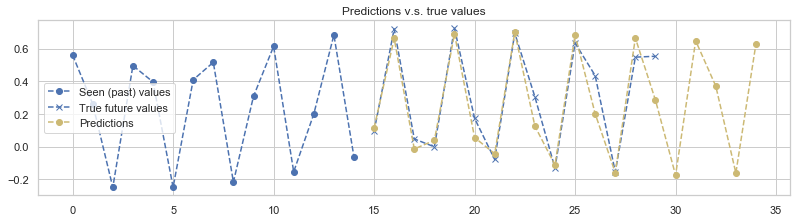

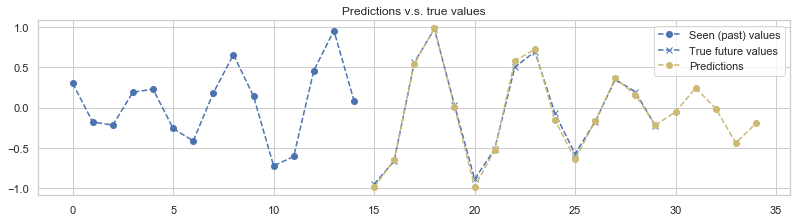

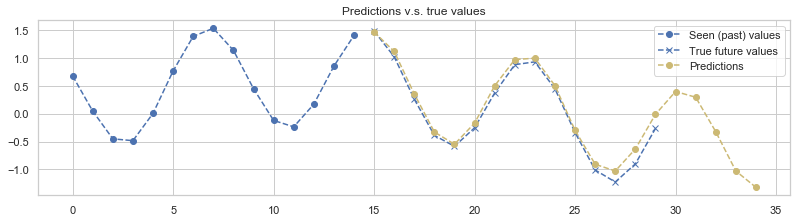

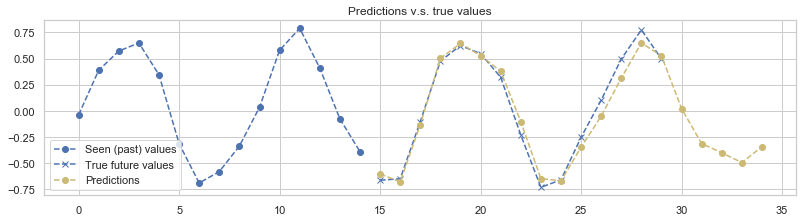

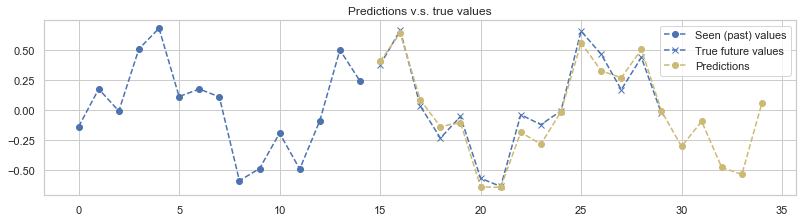

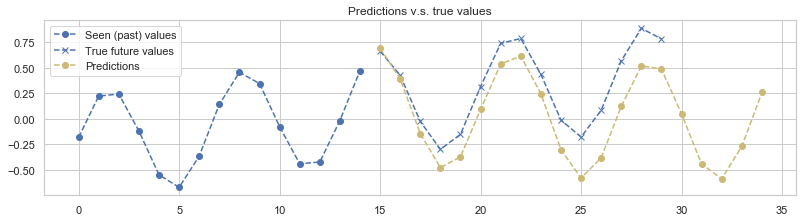

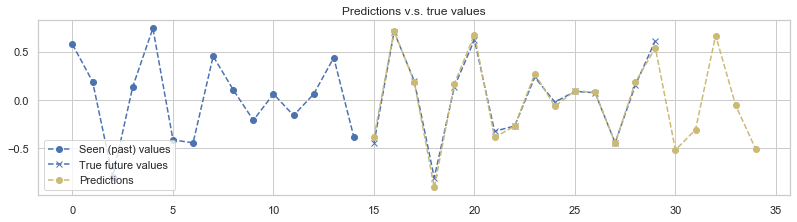

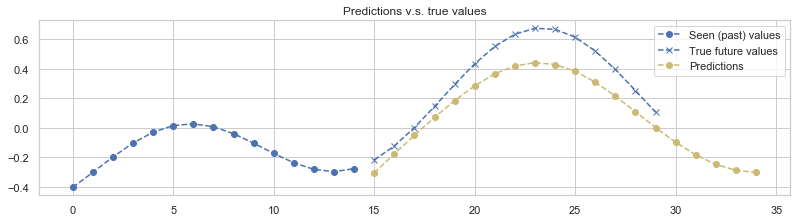

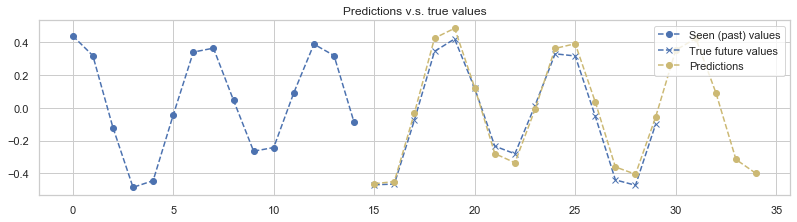

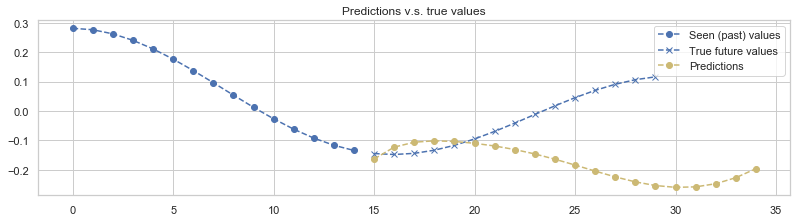

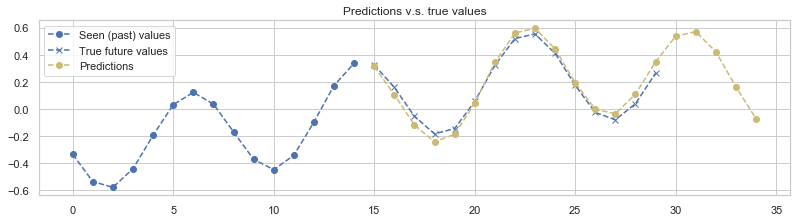

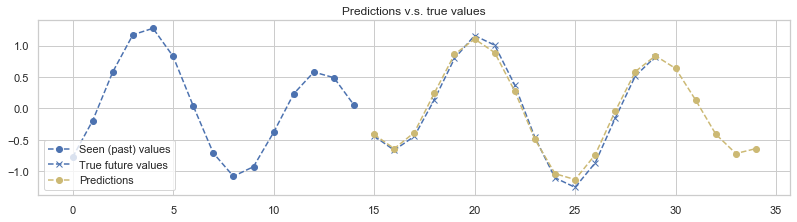

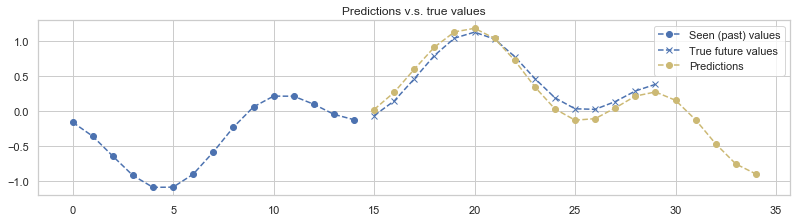

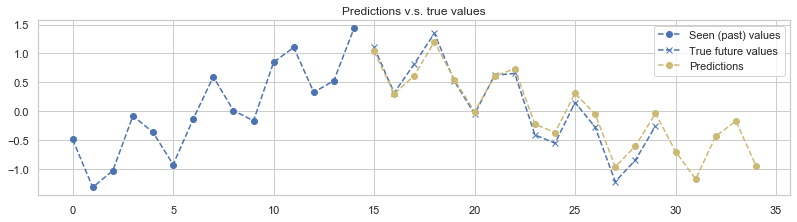

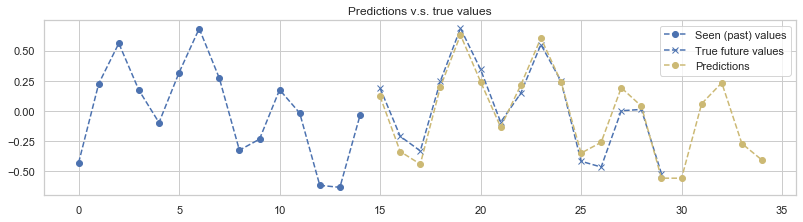

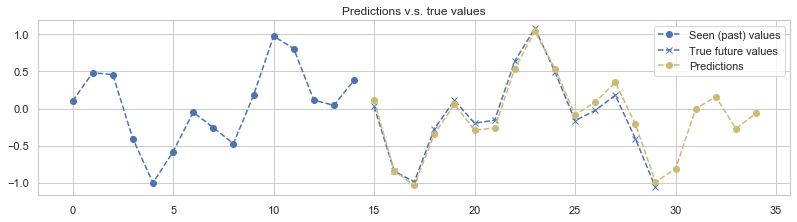

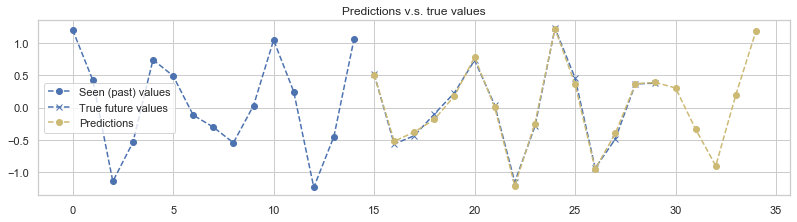

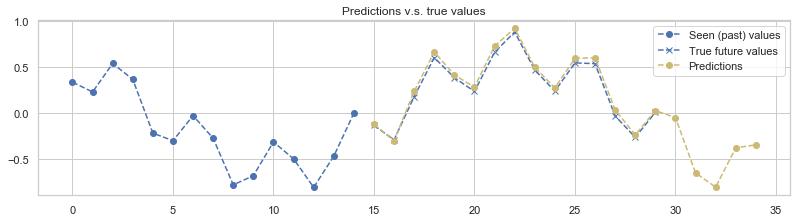

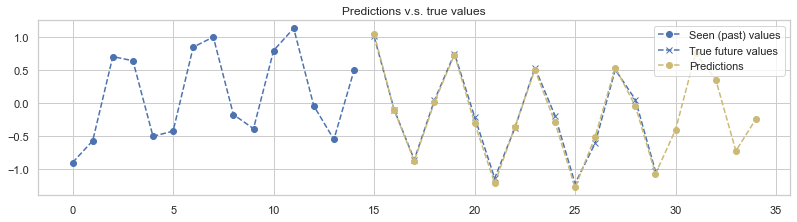

In [29]:

test_data_generator = random_sine(batch_size=1000,
                                  steps_per_epoch=steps_per_epoch,
                                  input_sequence_length=input_sequence_length,
                                  target_sequence_length=target_sequence_length,
                                  min_frequency=0.1, max_frequency=10,
                                  min_amplitude=0.1, max_amplitude=1,
                                  min_offset=-0.5, max_offset=0.5,
                                  num_signals=num_signals, seed=2000)

(x_encoder_test, x_decoder_test), y_test = next(test_data_generator) # x_decoder_test is composed of zeros.

y_test_predicted = model.predict([x_encoder_test, x_decoder_test])

encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

# Read layers backwards to fit the format of initial_state
# For some reason, the states of the model are order backwards (state of the first layer at the end of the list)
# If instead of a GRU you were using an LSTM Cell, you would have to append two Input tensors since the LSTM has 2 states.
for hidden_neurons in layers[::-1]:
    # One state for GRU
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

# Let's define a small function that predicts based on the trained encoder and decoder models

def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    """Predict time series with encoder-decoder.
    
    Uses the encoder and decoder models previously trained to predict the next
    num_steps_to_predict values of the time series.
    
    Arguments
    ---------
    x: input time series of shape (batch_size, input_sequence_length, input_dimension).
    encoder_predict_model: The Keras encoder model.
    decoder_predict_model: The Keras decoder model.
    num_steps_to_predict: The number of steps in the future to predict
    
    Returns
    -------
    y_predicted: output time series for shape (batch_size, target_sequence_length,
        ouput_dimension)
    """
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_predict_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

# The aim of this tutorial isn't to present how to evaluate the model or investigate the training.
# We could plot evaluation metrics such as RMSE over time, compare train and test batches for overfitting,
# produce validation and learning curves to analyse the effect of the number of epochs or training examples,
# have fun playing with tensorboard etc... We would need at least a whole other post for this.
# However, let's at least make sure that our model can predict correctly...
# Ask the generator to produce a batch of samples, don't forget to set the seed to something other than what was
# used for training or you will be testing on train data.
# The next function asks the generator to produce it's first batch.

test_data_generator = random_sine(batch_size=1000,
                                  steps_per_epoch=steps_per_epoch,
                                  input_sequence_length=input_sequence_length,
                                  target_sequence_length=target_sequence_length,
                                  min_frequency=0.1, max_frequency=10,
                                  min_amplitude=0.1, max_amplitude=1,
                                  min_offset=-0.5, max_offset=0.5,
                                  num_signals=num_signals, seed=2000)

(x_test, _), y_test = next(test_data_generator)

y_test_predicted = predict(x_test, encoder_predict_model, decoder_predict_model, num_steps_to_predict)

# Select 10 random examples to plot
indices = np.random.choice(range(x_test.shape[0]), replace=False, size=10)


for index in indices:
    plot_prediction(x_test[index, :, :], y_test[index, :, :], y_test_predicted[index, :, :])
    
# The model seems to struggle on very low wave signals. But that makes sense, the model doesn't see enough of the signal
# to make a good estimation of the frequency components.

train_data_generator = random_sine(batch_size=1000,
                                   steps_per_epoch=steps_per_epoch,
                                   input_sequence_length=input_sequence_length,
                                   target_sequence_length=target_sequence_length,
                                   min_frequency=0.1, max_frequency=10,
                                   min_amplitude=0.1, max_amplitude=1,
                                   min_offset=-0.5, max_offset=0.5,
                                   num_signals=num_signals, seed=1969)

(x_train, _), y_train = next(train_data_generator)

y_train_predicted = predict(x_train, encoder_predict_model, decoder_predict_model, num_steps_to_predict)

# Select 10 random examples to plot
indices = np.random.choice(range(x_train.shape[0]), replace=False, size=10)

for index in indices:
    plot_prediction(x_train[index, :, :], y_train[index, :, :], y_train_predicted[index, :, :])
    
    